In [1]:
# Mount Google Drive to access files in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install the MTCNN library for face detection
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.6 MB/s eta 0:00:00


In [3]:
import cv2 as cv
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pickle
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
# a Sample Image
img = cv.imread("/content/drive/MyDrive/FaceRec_Project/dataset/train/Abutreka/download (1).jpeg")

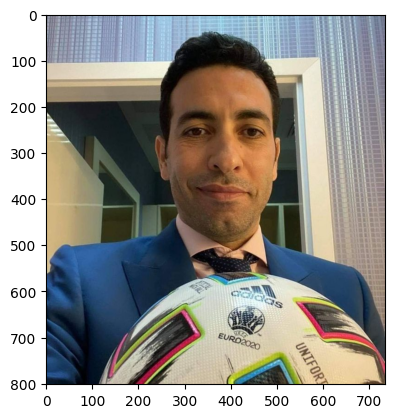

In [5]:
# Convert the image from BGR to RGB Then Show It
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) # RGB

In [6]:
# Create an MTCNN object to detect faces in the image
detector = MTCNN()
results = detector.detect_faces(img)
print(results)

[{'box': [244, 116, 256, 349], 'confidence': 0.9999996423721313, 'keypoints': {'nose': [395, 324], 'mouth_right': [436, 384], 'right_eye': [446, 254], 'left_eye': [324, 249], 'mouth_left': [331, 377]}}]


In [7]:
# Coordinates of the detected face (rectangle surrounding the face)
x,y,w,h = results[0]['box']

array([[[124, 130, 144],
        [114, 120, 134],
        [110, 116, 130],
        ...,
        [116, 121, 141],
        [126, 131, 151],
        [126, 131, 151]],

       [[120, 126, 140],
        [108, 114, 128],
        [103, 109, 123],
        ...,
        [116, 121, 141],
        [128, 133, 153],
        [130, 135, 155]],

       [[126, 132, 146],
        [111, 117, 131],
        [104, 110, 124],
        ...,
        [117, 122, 142],
        [130, 135, 155],
        [135, 140, 162]],

       ...,

       [[  6,  33,  54],
        [  6,  33,  54],
        [  7,  32,  54],
        ...,
        [109,  89,  65],
        [117,  99,  75],
        [122, 104,  82]],

       [[  7,  32,  54],
        [  7,  32,  54],
        [  9,  31,  52],
        ...,
        [108,  91,  65],
        [119, 103,  77],
        [125, 109,  84]],

       [[  9,  31,  54],
        [  9,  31,  54],
        [ 10,  31,  52],
        ...,
        [100,  84,  58],
        [114,  98,  72],
        [122, 106,  80]]], dtype=uint8)
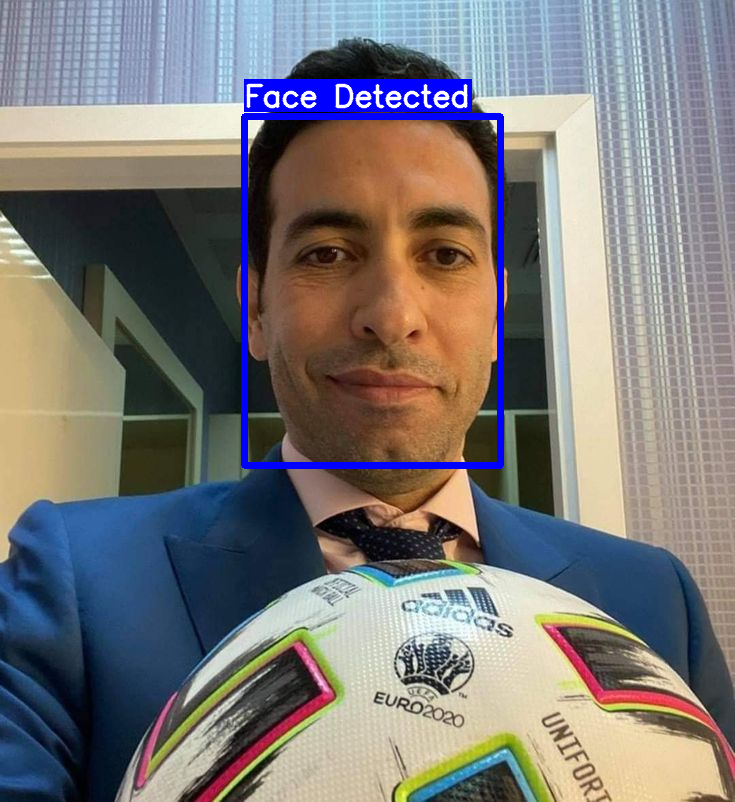

In [8]:
# Draws a rectangle around the face using the specified coordinates.
# رسم المستطيل
img = cv.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 5)

# إضافة النص فوق المستطيل
# النص المطلوب إضافته
text = "Face Detected"
font = cv.FONT_HERSHEY_SIMPLEX
font_scale = 1
text_color = (255, 255, 255)
thickness = 2
bg_color = (0, 0, 255)

# تحديد حجم النص
(text_width, text_height), _ = cv.getTextSize(text, font, font_scale, thickness)

text_x = x
text_y = y - 10
cv.rectangle(img, (text_x, text_y - text_height - 5), (text_x + text_width, text_y + 5), bg_color, -1)
cv.putText(img, text, (text_x, text_y), font, font_scale, text_color, thickness, cv.LINE_AA)


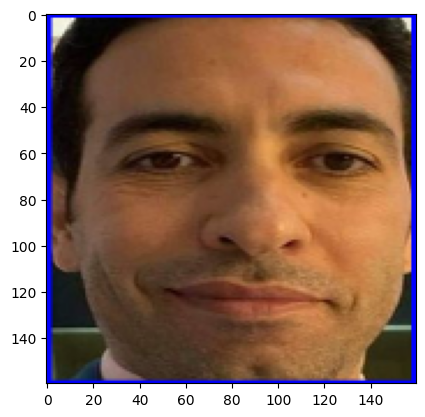

In [9]:
# Extract and resize the detected face to 160*160 pixels for FaceNet input
# I Choose 160*160 Because It's The Required Size For The FaceNet model.
face = img[y:y+h, x:x+w]

face = cv.resize(face, (160,160))
plt.imshow(face)

In [10]:
# تعريف فئة FACELOADING لتحميل واستخراج الوجوه
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)  # حجم الوجه بعد إعادة التحجيم
        self.X = []  # لتخزين الصور
        self.Y = []  # لتخزين التسميات (الأسماء)
        self.detector = MTCNN()  # كاشف الوجوه باستخدام MTCNN

    # استخراج الوجه من الصورة باستخدام MTCNN
    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        try:
            # الحصول على إحداثيات الوجه
            x, y, w, h = self.detector.detect_faces(img)[0]['box']
            x, y = abs(x), abs(y)
            face = img[y:y+h, x:x+w]
            face_arr = cv.resize(face, self.target_size)
            return face_arr
        except:
            return None  # إرجاع None في حال عدم اكتشاف وجه

    # تحميل الوجوه من دليل معين
    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                if single_face is not None:  # تأكد من أن الوجه تم اكتشافه
                    FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    # تحميل الفئات (الأشخاص) وصورهم إما من بيانات التدريب أو الاختبار
    def load_classes(self, is_train=True):
        for sub_dir in os.listdir(self.directory):
            path = self.directory + '/' + sub_dir + '/'
            FACES = self.load_faces(path)
            if is_train:
                labels = [sub_dir for _ in range(len(FACES))]
                print(f"Loaded successfully: {len(labels)} images from {sub_dir}")
                self.X.extend(FACES)
                self.Y.extend(labels)
            else:
                self.X.extend(FACES)  # فقط تحميل الصور بدون التسميات لمجموعة الاختبار

        if is_train:
            return np.asarray(self.X), np.asarray(self.Y)  # إرجاع الصور والتسميات
        else:
            return np.asarray(self.X), None  # إرجاع الصور فقط لمجموعة الاختبار

    # عرض الصور باستخدام Matplotlib
    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num, image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y) // ncols + 1
            plt.subplot(nrows, ncols, num + 1)
            plt.imshow(image)
            plt.axis('off')




In [11]:
# إنشاء كائن من فئة FACELOADING وتحميل الصور والتسميات من مجموعة التدريب
faceloading = FACELOADING("/content/drive/MyDrive/FaceRec_Project/dataset/train")
X_train, Y_train = faceloading.load_classes()  # تحميل الصور والتسميات

Loaded successfully: 9 images from Abutreka
Loaded successfully: 8 images from Robert
Loaded successfully: 9 images from AdelEmam
Loaded successfully: 9 images from Samuel
Loaded successfully: 9 images from Mohamed_Ali
Loaded successfully: 9 images from Ahmed_gamal
Loaded successfully: 9 images from ABDELRAHMAN_MOHAMED
Loaded successfully: 9 images from Messi
Loaded successfully: 8 images from Bahget_saper
Loaded successfully: 9 images from The_pig
Loaded successfully: 9 images from Tony_Soprano


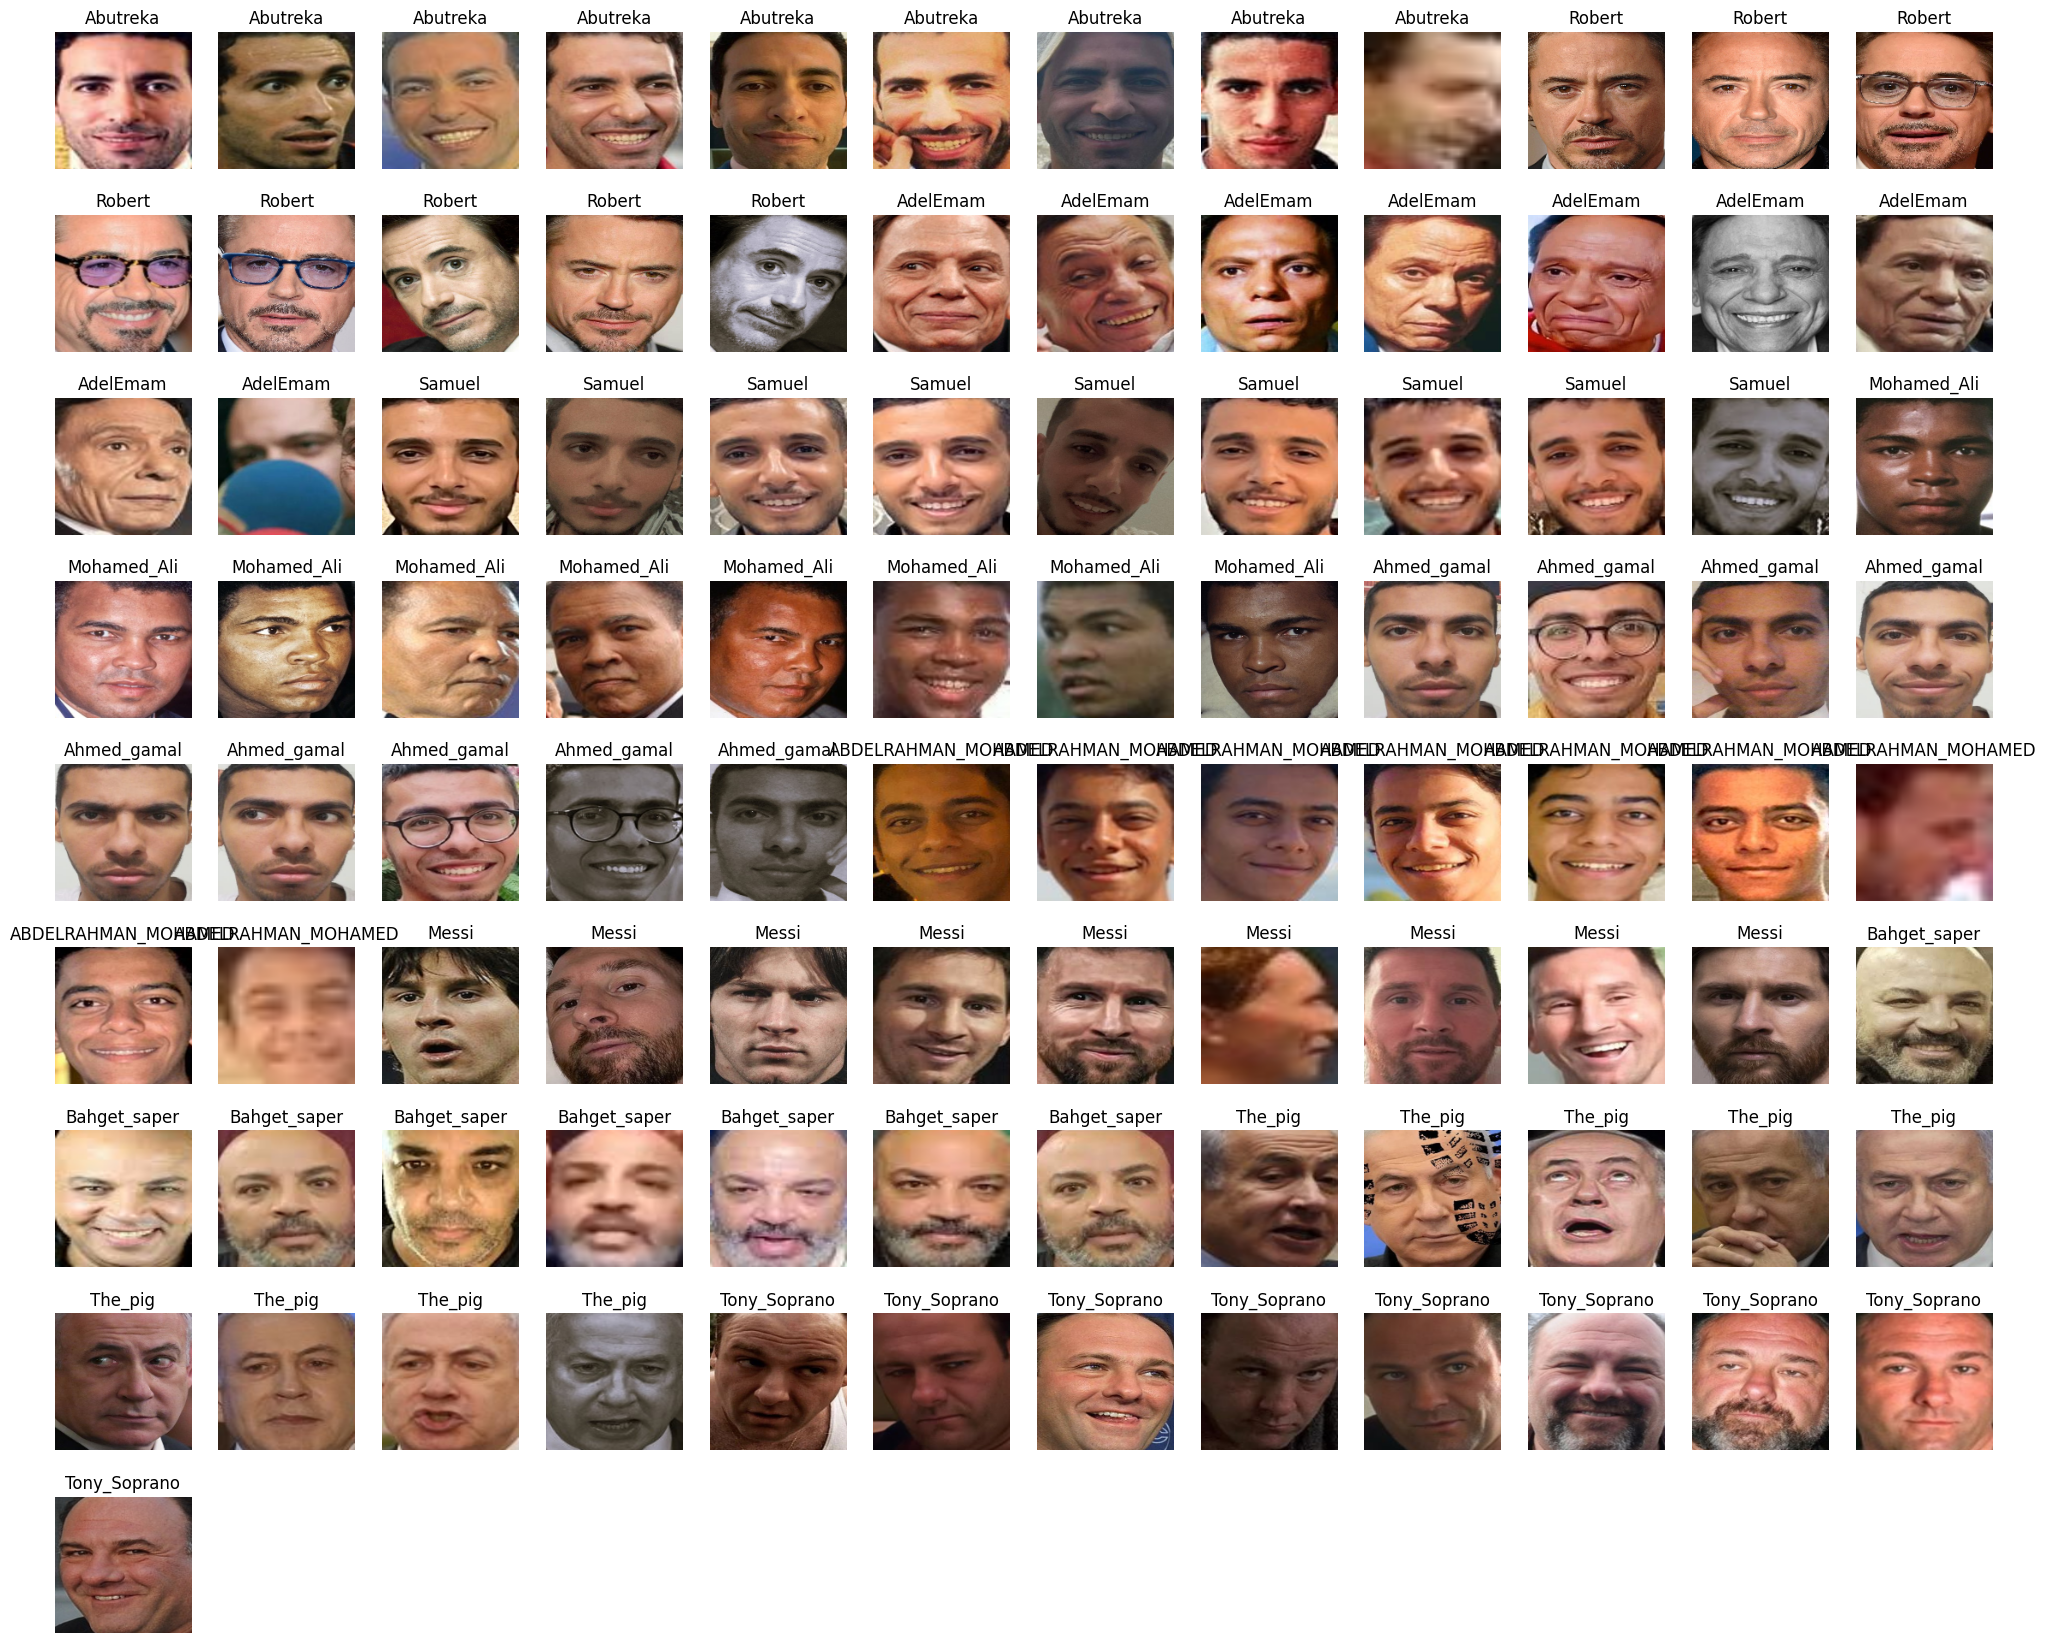

In [12]:
# عرض الصور المحملة من مجموعة التدريب
plt.figure(figsize=(25, 21))
for num, image in enumerate(X_train):
    ncols = 12
    nrows = len(Y_train) // ncols + 1
    plt.subplot(nrows, ncols, num + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(Y_train[num])

In [13]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10368 sha256=f45a1d3d4e2968a6bb05b3aec10703d4bddcd0f32752b097d21d752bbbefa4f4
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [14]:

train_loading = FACELOADING("/content/drive/MyDrive/FaceRec_Project/dataset/train")
X_train, Y_train = train_loading.load_classes(is_train=True)

test_loading = FACELOADING("/content/drive/MyDrive/FaceRec_Project/dataset/test")
X_test, _ = test_loading.load_classes(is_train=False)


Loaded successfully: 9 images from Abutreka
Loaded successfully: 8 images from Robert
Loaded successfully: 9 images from AdelEmam
Loaded successfully: 9 images from Samuel
Loaded successfully: 9 images from Mohamed_Ali
Loaded successfully: 9 images from Ahmed_gamal
Loaded successfully: 9 images from ABDELRAHMAN_MOHAMED
Loaded successfully: 9 images from Messi
Loaded successfully: 8 images from Bahget_saper
Loaded successfully: 9 images from The_pig
Loaded successfully: 9 images from Tony_Soprano


In [15]:
unknown_loading = FACELOADING("/content/drive/MyDrive/FaceRec_Project/dataset/unknown")
X_unknown, _ = unknown_loading.load_classes(is_train=False)


In [16]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32')
    face_img = np.expand_dims(face_img, axis=0)
    yhat = embedder.embeddings(face_img)
    return yhat[0]

In [17]:
EMBEDDED_X_train = []
for img in X_train:
    EMBEDDED_X_train.append(get_embedding(img))
EMBEDDED_X_train = np.asarray(EMBEDDED_X_train)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

In [18]:

EMBEDDED_X_test = []
for img in X_test:
    EMBEDDED_X_test.append(get_embedding(img))
EMBEDDED_X_test = np.asarray(EMBEDDED_X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

In [19]:

EMBEDDED_X_unknown = []
for img in X_unknown:
    EMBEDDED_X_unknown.append(get_embedding(img))
EMBEDDED_X_unknown = np.asarray(EMBEDDED_X_unknown)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [20]:
np.savez_compressed('faces_embeddings_train.npz', EMBEDDED_X_train, Y_train)
np.savez_compressed('faces_embeddings_test.npz', EMBEDDED_X_test)
np.savez_compressed('faces_embeddings_unknown.npz', EMBEDDED_X_unknown)

In [21]:

from sklearn.preprocessing import LabelEncoder


In [22]:
all_labels = list(Y_train) + ['unknown']
encoder = LabelEncoder()
encoder.fit(all_labels)

Y_train = encoder.transform(Y_train)
unknown_labels = ['unknown'] * EMBEDDED_X_unknown.shape[0]
Y_unknown = encoder.transform(unknown_labels)

X_combined = np.vstack((EMBEDDED_X_train, EMBEDDED_X_unknown))
Y_combined = np.hstack((Y_train, Y_unknown))



In [23]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_combined, Y_combined, shuffle=True, random_state=17)


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

grid = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END ....................C=0.1, gamma=0.1, 

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [25]:
print("Best Parameters found by Grid Search:", grid.best_params_)

Best Parameters found by Grid Search: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [26]:
def predict_with_name(test_im, model, encoder, confidence_threshold=0.5):
    ypreds = model.predict(test_im)
    probabilities = model.predict_proba(test_im)
    confidence = np.max(probabilities)

    if confidence < confidence_threshold:
        return 'unknown'
    predicted_label = encoder.inverse_transform(ypreds)
    return predicted_label[0]

In [27]:

ypreds_train = grid.predict(X_train)
ypreds_val = grid.predict(X_val)

In [28]:

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(Y_train, ypreds_train)
accuracy_val = accuracy_score(Y_val, ypreds_val)

print("Training Accuracy:", accuracy_train)
print("Validation Accuracy:", accuracy_val)


Training Accuracy: 0.9954545454545455
Validation Accuracy: 0.9863945578231292


In [30]:
t_im = cv.imread("/content/drive/MyDrive/FaceRec_Project/uploaded_images/1.jpeg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x, y, w, h = detector.detect_faces(t_im)[0]['box']
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160, 160))
test_im = get_embedding(t_im)
test_im = [test_im]

predicted_name = predict_with_name(test_im, grid, encoder)
print("Predicted label:", predicted_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted label: Tony_Soprano


In [31]:
import pickle
with open('svm_model_with_names.pkl', 'wb') as f:
    pickle.dump((grid, encoder), f)

with open('svm_model_with_names.pkl', 'rb') as f:
    grid, encoder = pickle.load(f)

In [32]:
#===================================================================================================================
#===================================================================================================================
#===================================================================================================================
#===================================================================================================================
#===================================================================================================================
#===================================================================================================================
#===================================================================================================================
#===================================================================================================================

Saving The King With His Crown👑.jpeg to The King With His Crown👑.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


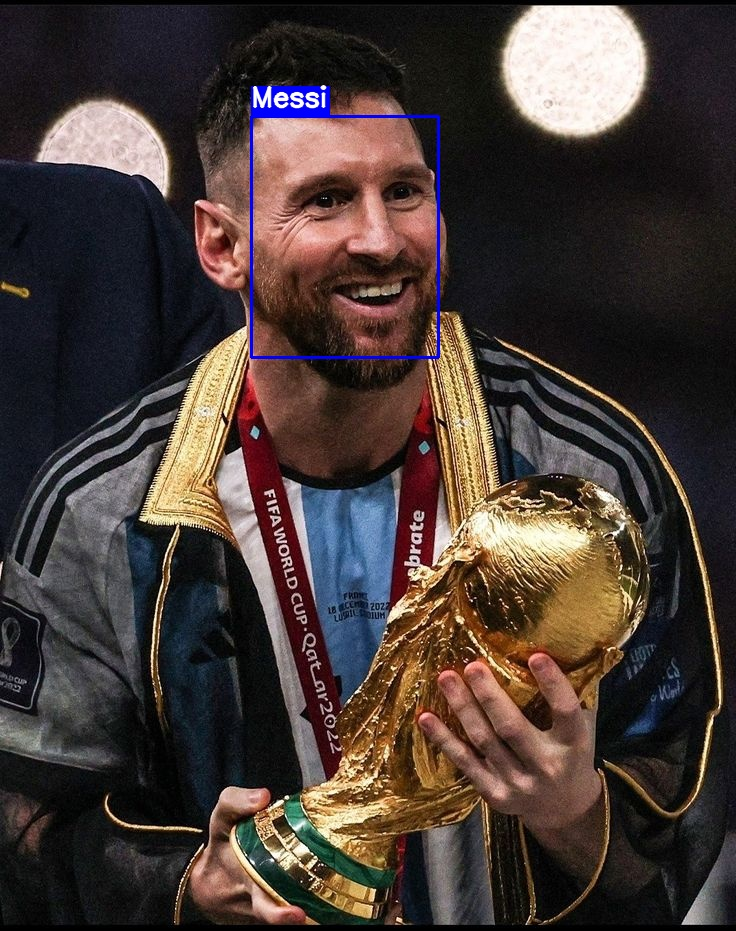

In [36]:
################      TEST THE Model      ################
import os
from google.colab import files
import cv2 as cv
from google.colab.patches import cv2_imshow

output_folder = "/content/drive/MyDrive/FaceRec_Project/uploaded_images"
os.makedirs(output_folder, exist_ok=True)

uploaded = files.upload()

for filename in uploaded.keys():
    t_im = cv.imread(filename)

    results = detector.detect_faces(t_im)
    if results:
        x, y, w, h = results[0]['box']
        face_img = t_im[y:y + h, x:x + w]
        face_img = cv.resize(face_img, (160, 160))

        test_im = get_embedding(face_img)
        test_im = [test_im]

        ypreds = grid.predict(test_im)
        predicted_label = encoder.inverse_transform(ypreds)[0]


        cv.rectangle(t_im, (x, y), (x + w, y + h), (255, 0, 0), 2)


        font = cv.FONT_HERSHEY_SIMPLEX
        font_scale = 0.9
        text_color = (255, 255, 255)
        thickness = 2
        bg_color = (255, 0, 0)

        (text_width, text_height), _ = cv.getTextSize(predicted_label, font, font_scale, thickness)

        cv.rectangle(t_im, (x, y - text_height - 10), (x + text_width, y), bg_color, cv.FILLED)


        cv.putText(t_im, predicted_label, (x, y - 10), font, font_scale, text_color, thickness, cv.LINE_AA)

        output_path = os.path.join(output_folder, filename)
        cv.imwrite(output_path, t_im)

    else:
        print(f"Unknown {filename}")

for img_name in uploaded.keys():
    img = cv.imread(os.path.join(output_folder, img_name))
    cv2_imshow(img)
